# Variational auto-encoder for analysing PBMC 3K data

## Load pre-analysed data
Data generated via the scanpy's [pbmc3k tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
adata = sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


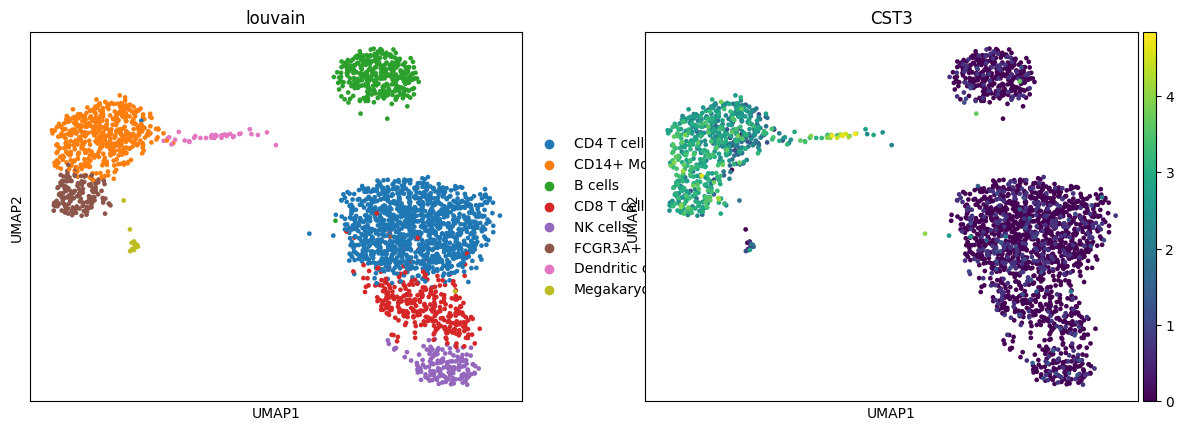

In [4]:
sc.pl.umap(adata, color=["louvain", "CST3"])

In [5]:
adata.X

array([[-0.17146951, -0.28081203, -0.04667679, ..., -0.09826884,
        -0.2090951 , -0.5312034 ],
       [-0.21458222, -0.37265295, -0.05480444, ..., -0.26684406,
        -0.31314576, -0.5966544 ],
       [-0.37688747, -0.2950843 , -0.0575275 , ..., -0.15865596,
        -0.17087643,  1.379     ],
       ...,
       [-0.2070895 , -0.250464  , -0.046397  , ..., -0.05114426,
        -0.16106427,  2.0414972 ],
       [-0.19032837, -0.2263336 , -0.04399938, ..., -0.00591773,
        -0.13521303, -0.48211113],
       [-0.33378917, -0.2535875 , -0.05271563, ..., -0.07842438,
        -0.13032717, -0.4713379 ]], dtype=float32)

In [6]:
# after normalize_total and log1p
adata_raw = adata.raw.to_adata()
adata_raw

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    obsp: 'distances', 'connectivities'

In [7]:
# adata_raw[:, adata.var.index].X.A

## Varitional Auto-Encoder with nnlite
For the Auto-encoder notebook, see [PBMC3K_AE.ipynb](./PBMC3K_AE.ipynb).

In [8]:
import torch
from torch import nn, Tensor
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(Tensor(adata.X))
train_loader = DataLoader(train_data, batch_size=256, shuffle=False, drop_last=False)

In [9]:
import nnlite
print(nnlite.__version__)

0.0.3


In [10]:
from functools import partial
from nnlite import NNWrapper

torch.manual_seed(0)
dev = 'cuda:5' if torch.cuda.is_available() else 'cpu'

## VAE with one hidden layers dim=64
model = nnlite.models.VAE_base(1838, 32, hidden_dims=[64], device=dev)

## Loss: ELBO with beta (see more issues in the last section)
criterion = partial(nnlite.models.Loss_VAE_Gaussian, beta=1e-3)
# criterion = partial(nnlite.models.Loss_VAE_Gaussian, beta=1e-3, fix_x_var=True)

## optimizer: with sum over dim the gradient is large, so needs small lr
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

my_wrapper = NNWrapper(model, criterion, optimizer, device=dev)
my_wrapper.fit(train_loader, epoch=3000, validation_loader=None, verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:38<00:00, 13.74it/s]


In [11]:
model

VAE_base(
  (encoder): Sequential(
    (0): Identity()
    (L0): Linear(in_features=1838, out_features=64, bias=True)
    (A0): ReLU()
  )
  (fc_z_mean): Linear(in_features=64, out_features=32, bias=True)
  (fc_z_logstd): Linear(in_features=64, out_features=32, bias=True)
  (decoder): Sequential(
    (L0): Linear(in_features=32, out_features=64, bias=True)
    (A0): ReLU()
  )
  (fc_x_mean): Linear(in_features=64, out_features=1838, bias=True)
  (fc_x_logstd): Linear(in_features=1, out_features=1838, bias=False)
)

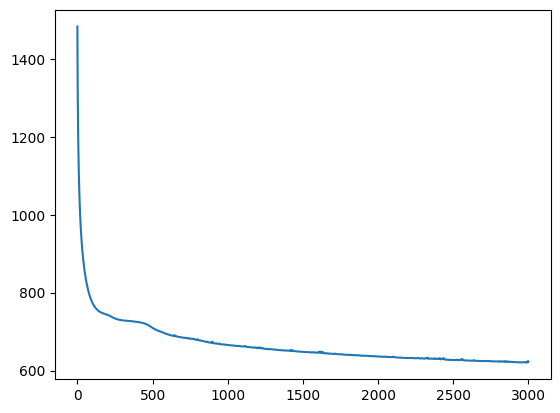

In [12]:
plt.plot(my_wrapper.train_losses)

In [13]:
data_X = Tensor(adata.X).to(torch.device(dev))
data_Z = model.encoder(data_X)

In [14]:
data_Z

tensor([[0.0000, 0.0000, 0.0279,  ..., 0.5836, 0.0000, 1.5843],
        [3.5334, 0.0000, 0.0000,  ..., 0.0000, 0.0426, 1.2766],
        [0.0000, 0.0000, 0.7042,  ..., 0.0000, 0.0000, 0.4690],
        ...,
        [2.9575, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9178],
        [4.1918, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.3933],
        [0.0176, 2.1189, 0.0000,  ..., 0.2182, 0.2595, 0.0000]],
       device='cuda:5', grad_fn=<ReluBackward0>)

In [15]:
adata1 = adata.copy()
adata1.obsm['X_pca'] = data_Z.cpu().data.numpy()

sc.pp.neighbors(adata1, n_neighbors=10, n_pcs=32)
sc.tl.umap(adata1)

/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/ssd/users/yuanhua/envs/PyTch/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


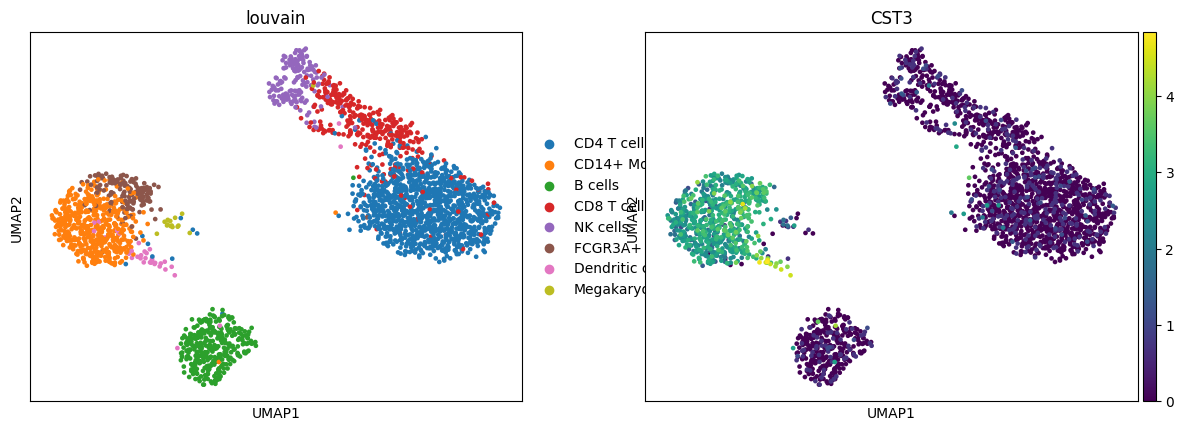

In [16]:
sc.pl.umap(adata1, color=["louvain", "CST3"])

**Issues on defining the loss `Loss_VAE_Gaussian` (for good optimal and stable optimization):**
1. somehow the prior is too strong
- Option 1: with smaller beta, e.g., `beta=1e-3`
- Option 2: with broader prior but slightly poorer, e.g., `beta=1.0, prior_sigma=3.0`

2. general challenge on the variance for likelihood
- Option 1: fix x_var to a certain value, e.g., `fix_x_var=True`
- Option 2: optimize x_var and other parameters alternately (not implemented yet).

In [17]:
# model.fc_x_logstd.weight
# model.x_logstd